In [1]:
import sys
import time
import random
import csv
import numpy as np

import scipy.io
from scipy.io import loadmat

import torch
import pickle

from tqdm import tqdm
from tqdm import notebook

import matplotlib
import matplotlib.pyplot as plt

import importlib
import utils

# Enable autoreload
%load_ext autoreload
%autoreload 2
importlib.reload(utils)

# Set seeds for reproducibility
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)
    torch.cuda.manual_seed_all(0)  # if you are using multi-GPU.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

TORCH_DTYPE = torch.float64 #NB: Basically all of the matrices in Spatial_GP have 1.e-7 added to the diagonal, to be changed if we want to use float64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
torch.set_default_dtype(TORCH_DTYPE)
torch.set_default_device(device)
print(f'Device is: {device}')



Using device: cuda:0 (from utils.py)
Using device: cuda:0 (from utils.py)
Device is: cuda:0


### How this works:

We choose initial training points to be considered a random set of images to present to the retina. On this set, the complete GP will be run , to find STA paramaters eps_0: center, beta: width , rho: smoothness

We run the algorithm saving the seed used for picking the training images, so that this set can be changed and different runs with different initial conditions can be averaged.

1. Import the dataset and create a total training set X,R
2. Pick the cell and the initial training points, extracted randomly. These correspond also to the number of inducing points
3. Save the seed so you can keep the initial training set, and the fitted model
3. 


### Parameters of the training

In [2]:
rand_xtilde = True # If True, xtilde (inducing points) are chosen randomly, if False, xtilde is chosen from the first ntilde images

cellid       = 8         # Choose cell
ntrain_start = 10        # Number of first training data points

kernfun      = 'acosker' # Choose kernel function

nEstep       = 10         # Total number of E-steps iterations.
nFparamstep  = 10  
nMstep       = 10         # Total number of M-steps iterations. 
maxiter      = 10         # Iterations of the optimization algorithm comprising M and E steps

ntilde       = ntrain_start

### Import dataset and generate starting dataset

Create starting dataset on which to train with m step with ntilde = ntrain_start

In [3]:
# Open the .pkl dataset file for reading in binary mode (rb)
with open('/home/idv-eqs8-pza/IDV_code/Variational_GP/spatial_GP/Data/data2_41mixed_tr28.pkl', 'rb') as file:
    # Load the data from the file
    loaded_data = pickle.load(file)
    # loaded_data is a Dataset object from module Data with attributes "images_train, _val, _test" as well as responses

X_train = torch.tensor(loaded_data.images_train).to(device, dtype=TORCH_DTYPE) #shape (2910,108,108,1) where 108 is the number of pixels. 2910 is the amount of training points
X_val   = torch.tensor(loaded_data.images_val).to(device, dtype=TORCH_DTYPE)
X_test  = torch.tensor(loaded_data.images_test).to(device, dtype=TORCH_DTYPE) # shape (30,108,108,1) # nimages, npx, npx

R_train = torch.tensor(loaded_data.responses_train).to(device, dtype=TORCH_DTYPE) #shape (2910,41) 2910 is the amount of training data, 41 is the number of cells
R_val   = torch.tensor(loaded_data.responses_val).to(device, dtype=TORCH_DTYPE)
R_test  = torch.tensor(loaded_data.responses_test).to(device, dtype=TORCH_DTYPE) # shape (30,30,42) 30 repetitions, 30 images, 42 cells

# Create the complete dataset
X = torch.cat( (X_train, X_val), axis=0,) #shape (3160,108,108,1)
R = torch.cat( (R_train, R_val), axis=0,)
n_px_side = X.shape[1]  

# Reshape images to 1D vector and choose a cell
X = torch.reshape(X, ( X.shape[0], X.shape[1]*X.shape[2])) 
R = R[:,cellid] # shape (nt,) where nt is the number of trials

# Choose a random subset of the data and save the idx
all_idx  = torch.arange(0, X.shape[0])                     # Indices of the whole dataset  
torch.manual_seed(0)
torch.cuda.manual_seed(0)
all_idx_perm = torch.randperm(all_idx.shape[0])            # Random permutation of the indices
rndm_idx = all_idx_perm[:ntrain_start]                     # These will be the indices of the initial training. This way ensures not repetitions.
# rndm_idx = torch.randint(0, X.shape[0], (ntrain_start,))   # These will be the indices of the initial training 


start_idx     = rndm_idx.sort()[0]
in_use_idx    = start_idx
xtilde_idx    = in_use_idx
remaining_idx = all_idx[~torch.isin( all_idx, in_use_idx )].sort()[0]

# Set the starting set
xtilde_start  = X[xtilde_idx,:]                           # In the simplest case the starting points are all inducing points
X_in_use      = X[in_use_idx,:]
X_remaining   = X[remaining_idx,:]

R_remaining   = R[remaining_idx]
R_in_use      = R[in_use_idx]

# Estimate memory usage
# Calculate memory usage for each tensor
X_memory = X.element_size() * X.nelement()
r_memory = R.element_size() * R.nelement()
# Total memory usage in bytes
total_memory_bytes = X_memory + r_memory
# Convert bytes to megabytes (MB)
total_memory_MB = total_memory_bytes / (1024 ** 2)
print(f'Total dataset memory on GPU: {total_memory_MB:.2f} MB')

Total dataset memory on GPU: 281.23 MB


### Select cell, starting hyperparameters and firing rate parameters

In [4]:
# For details on the hyperparameters choice see one_cell_fit.ipynb
logbetaexpr = utils.fromlogbetasam_to_logbetaexpr( logbetasam=torch.tensor(5.5) )# Logbetaexpr in this code is equal to logbeta in Samuele's code. Samuele's code set logbeta to 5.5
logrhoexpr  = utils.fromlogrhosam_to_logrhoexpr( logrhosam=torch.tensor(5)) 
# logbetaexpr = torch.tensor(4.65)
# logrhoexpr = torch.tensor(4.3)
# logsigma_0 = torch.tensor(0) 
# sigma_0    = torch.exp(logsigma_0)
sigma_0    = torch.tensor(1.0)
Amp        = torch.tensor(1.0) 
eps_0x     = torch.tensor(0.0001)
eps_0y     = torch.tensor(0.0001)
# Hypermarameters, if needed to be set manually
theta = {'sigma_0': sigma_0, 'Amp': Amp, 'eps_0x':eps_0x, 'eps_0y':eps_0y, '-2log2beta': logbetaexpr, '-log2rho2': logrhoexpr,  }

# Set the gradient of the hyperparemters to be updatable 
for key, value in theta.items():
    # to exclude a single hyperparemeters from the optimization ( to exclude them all just set nmstep=0 and dont do the M-step)
    # if key == 'Amp':
        # continue
    theta[key] = value.requires_grad_()

# If hyperparameters are set manually:
hyperparams_tuple = utils.generate_theta( x=X_in_use, r=R_in_use, n_px_side=n_px_side, display=True, **theta)
# If hyperparameters are set based on the STAs:
# hyperparams_tuple = utils.generate_theta( x=X, r=r, n_px_side=n_px_side, display=True)

A        = torch.tensor(0.01)
logA     = torch.log(A)
# lambda0  = torch.tensor(0.31)
lambda0  = torch.tensor(1.)
# f_params = {'logA': logA, 'loglambda0':torch.log(lambda0)}
f_params = {'logA': logA, 'lambda0':lambda0}

for key, value in f_params.items():
    f_params[key] = value.requires_grad_()

fit_parameters = {'ntilde':      ntilde,
                  'maxiter':     maxiter,
                  'nMstep':      nMstep,
                  'nEstep':      nEstep,
                  'nFparamstep': nFparamstep,
                  'kernfun':     kernfun,
                  'cellid':      cellid,
                  'n_px_side':   n_px_side,
                  'in_use_idx':  in_use_idx,     # Used idx for generating xtilde, referred to the whole X dataset
                  'xtilde_idx':  xtilde_idx,     # Used idx for generating the complete set, referred to the whole X dataset
                  'start_idx':   start_idx }     # Indexes used to generate the initial training set, same as the starting xtilde

init_model = {
        'fit_parameters':    fit_parameters,
        'xtilde':            xtilde_start,
        'hyperparams_tuple': hyperparams_tuple,     # Contains also the upper and lower bounds for the hyperparameters
        'f_params':          f_params,
        'm':                 torch.zeros( (ntilde) )
        # 'm': torch.ones( (ntilde) )
        #'V': dont initialize V if you want it to be initialized as K_tilde and projected _exactly_ as K_tilde_b for stabilisation
    }


updated sigma_0 to 1.0000
updated Amp to 1.0000
updated eps_0x to 0.0001
updated eps_0y to 0.0001
updated -2log2beta to 4.8069
updated -log2rho2 to 4.3069


### Fit the starting model
And save it needed to start a new active fit

*Iteration*:   1 E-step took: 0.2795s, M-step took: 0.0887s
*Iteration*:   2 E-step took: 0.1593s, M-step took: 0.0833s
*Iteration*:   3 E-step took: 0.1368s, M-step took: 0.0892s
*Iteration*:   4 E-step took: 0.1300s, M-step took: 0.0845s
*Iteration*:   5 E-step took: 0.1327s, M-step took: 0.0799s
*Iteration*:   6 E-step took: 0.1295s, M-step took: 0.0870s
*Iteration*:   7 E-step took: 0.1349s, M-step took: 0.0842s
*Iteration*:   8 E-step took: 0.1314s, M-step took: 0.0909s
*Iteration*:   9 E-step took: 0.1610s
Time total after init:        2.106s
Time total before init:       2.165s
Final Loss: 6.8386


 Pietro's model: R2 = 0.12 ± 0.00 Cell: 8 maxiter = 10, nEstep = 10, nMstep = 10 



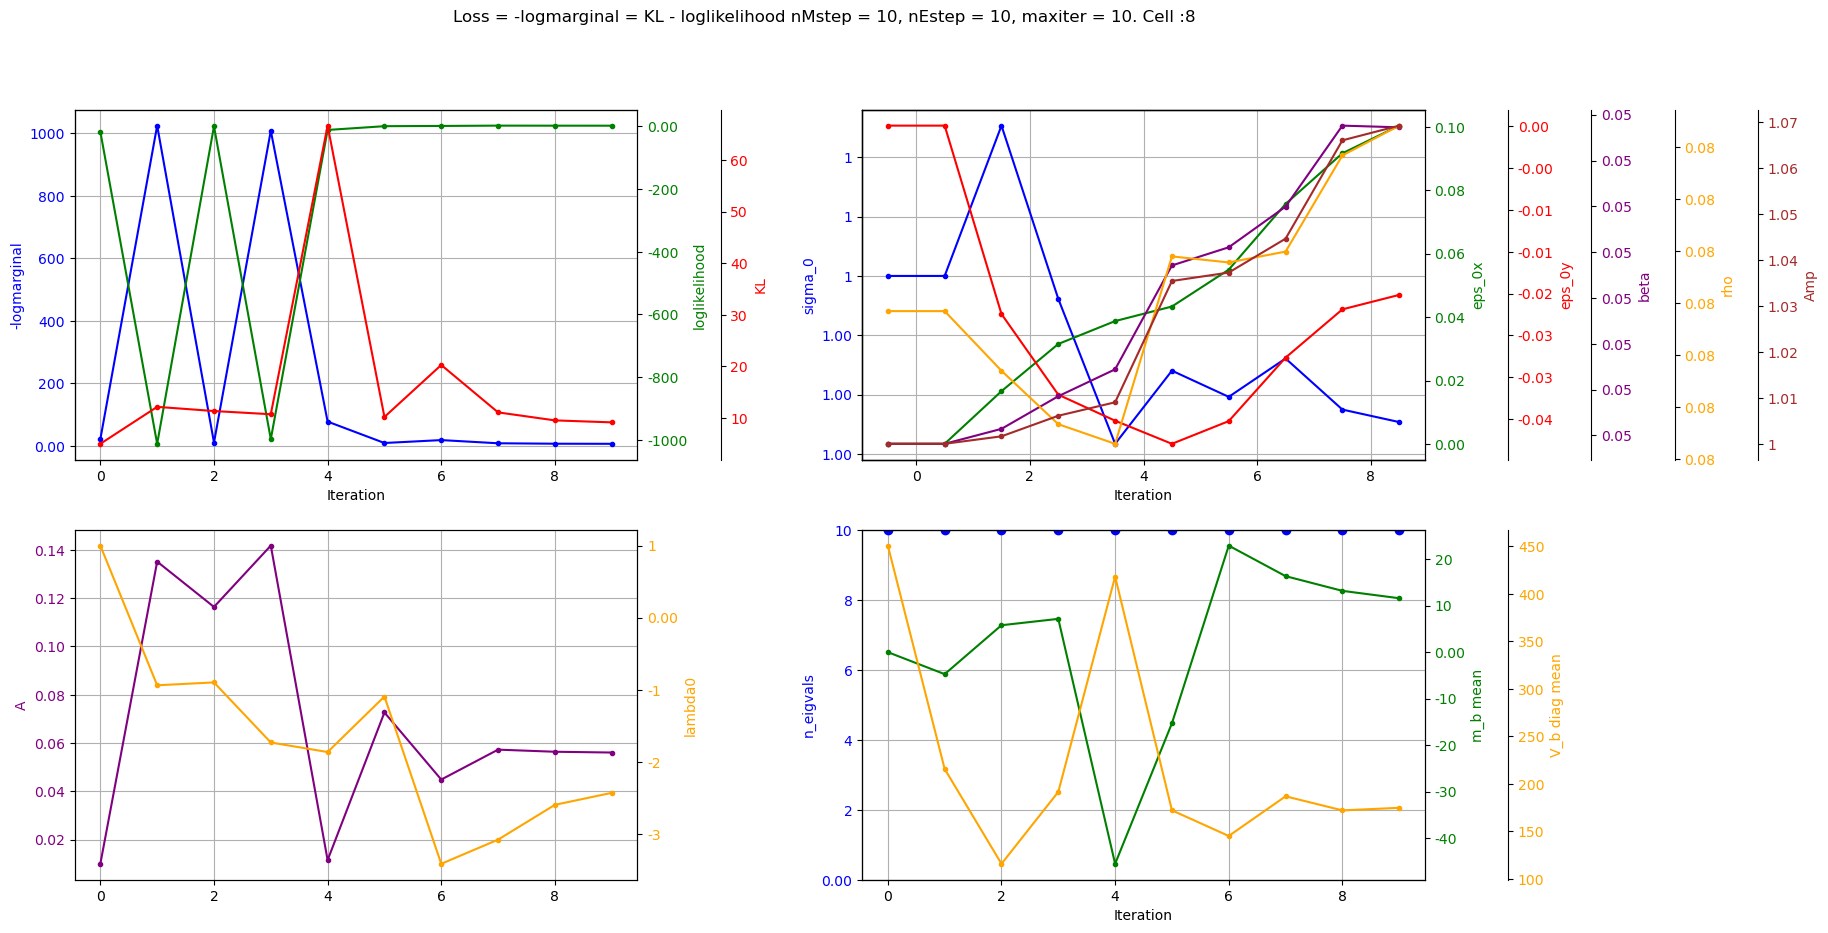

In [5]:
fit_model, err_dict = utils.varGP(X_in_use, R_in_use, **init_model)

# Save the model. All of the matrices are projected in the eigenspace of big eigenvalues of K_tilde. Indicated by _b
# start_model = fit_model

if err_dict['is_error']:
    print('Error in the fit')
    raise err_dict['error']

# Save the model
# utils.save_model(start_model, f'models/starting_models_active_learning/cell:{cellid}_nstart:{ntrain_start}', additional_description='Starting model for active learning')

spk_count_test, spk_count_pred, r2, sigma_r2 = utils.test(X_test, R_test, X_train=X, at_iteration=None, **fit_model )
utils.plot_loss_and_theta_notebook(fit_model, figsize=(15,10), marker='.')#ylim_logmarg=(0, 5000))


### Save or load model

In [6]:
# Save the model
# utils.save_model(start_model, f'models/starting_models_active_learning/cell:{cellid}_nstart:{ntrain_start}', additional_description='Starting model for active learning')
# start_model = utils.load_model(f'models/starting_models_active_learning/cell:8_nstart:20')

### Evaluate the utility of each remaining image
New version

In [7]:
in_use_idx    = start_model['fit_parameters']['in_use_idx']
xtilde_idx    = start_model['fit_parameters']['xtilde_idx']

remaining_idx = all_idx[~torch.isin( all_idx, in_use_idx )].sort()[0]

X_remaining = X[remaining_idx]
R_remaining = R[remaining_idx]

xtilde      = X[xtilde_idx]  # This has to be the same as start_model['xtilde']

xstar = X_remaining

kernfun       = start_model['fit_parameters']['kernfun']
mask          = start_model['mask']
C             = start_model['C']
B             = start_model['B']
K_tilde_b     = start_model['K_tilde_b']
K_tilde_inv_b = start_model['K_tilde_inv_b']
K_b           = start_model['K_b']
Kvec          = start_model['Kvec']
m_b           = start_model['m_b']
V_b           = start_model['V_b']    
f_params_fit  = start_model['f_params']
A             = torch.exp(f_params_fit['logA'])
lambda0       = torch.exp(f_params_fit['loglambda0']) if 'loglambda0' in f_params_fit else f_params_fit['lambda0']

start_time = time.time()

# Calculate the matrices to compute the lambda moments. They are referred to the unseen images xstar
Kvec = utils.acosker(theta, xstar[:,mask], x2=None, C=C, dC=None, diag=True)
K    = utils.acosker(theta, xstar[:,mask], x2=xtilde_start[:,mask], C=C, dC=None, diag=False)
K_b  = K @ B 

lambda_m_t, lambda_var_t = utils.lambda_moments( xstar[:,mask], K_tilde_b, K_b@K_tilde_inv_b, Kvec, K_b, C, m_b, V_b, theta, kernfun)  

logf_mean = A*lambda_m_t + lambda0
logf_var  = A**2 * lambda_var_t

# Estimate the utility and cap the maximum r ( used in a summation to infinity )
r_masked = torch.arange(0, 100, dtype=TORCH_DTYPE)
u2d = utils.nd_utility(logf_var, logf_mean, r_masked )
print(f'\nElapsed time for lambda moments and utility : {time.time()-start_time:.2f} seconds')  


NameError: name 'start_model' is not defined

### Find the index(es) for the most useful image 
Check the correspondence between the index: ```i_best``` of the ```xstar = X_remaining``` images with the one: ```x_idx_best```  for the complete dataset ```X```

In [ ]:
i_best     = u2d.argmax()           # Index of the best image in the utility vector
x_idx_best = remaining_idx[i_best]  # Index of the best image in the dataset indices
print(f'Utility: {u2d[i_best].item():<8.4f} |  Best image ID: {i_best}  | Best image index: {x_idx_best}')


# Using the indexes of the utility
Kvec = utils.acosker(theta, xstar[:,mask], x2=None, C=C, dC=None, diag=True)
K    = utils.acosker(theta, xstar[:,mask], x2=xtilde_start[:,mask], C=C, dC=None, diag=False)
K_b  = K @ B 

lambda_m_t, lambda_var_t = utils.lambda_moments( xstar[:,mask], K_tilde_b, K_b@K_tilde_inv_b, Kvec, K_b, C, m_b, V_b, theta, kernfun)  
logf_mean = A*lambda_m_t + lambda0
logf_var  = A**2 * lambda_var_t
print(f' this has utility {utils.nd_utility(logf_var[i_best], logf_mean[i_best], r_masked)} and f_mean :{torch.exp(logf_mean[i_best]).item():8.4f}')


# Using the indixes of the dataset X
# Calculate the matrices to compute the lambda moments. They are referred to the unseen images xstar
Kvec = utils.acosker(theta, X[x_idx_best,mask][None,:], x2=None, C=C, dC=None, diag=True)
K    = utils.acosker(theta, X[x_idx_best,mask][None,:], x2=xtilde_start[:,mask], C=C, dC=None, diag=False)
K_b  = K @ B 
lambda_m_t, lambda_var_t = utils.lambda_moments( X[x_idx_best,mask][None,:], K_tilde_b, K_b@K_tilde_inv_b, Kvec, K_b, C, m_b, V_b, theta, kernfun)  
logf_mean = A*lambda_m_t + lambda0
logf_var  = A**2 * lambda_var_t
print(f' this has utility {utils.nd_utility(logf_var, logf_mean, r_masked)} and f_mean :{torch.exp(logf_mean).item():8.4f}')

Utility: 3.7330   |  Best image ID: 613  | Best image index: 721
 this has utility tensor([3.7330], device='cuda:0') and f_mean : 19.6462
 this has utility tensor([3.7330], device='cuda:0') and f_mean : 19.6462


In [8]:
xtilde_start.shape
fit_model['B'].shape

torch.Size([500, 39])

### Update the indexes tensors and fit the new model


Elapsed time for lambda moments and utility : 0.04 seconds
Utility: 2.3760   |  Best image ID: 1316  | Best image index: 1538
 this has utility tensor([2.3760], device='cuda:0') and f_mean : 11.3712 Using indexes of utility
 this has utility tensor([2.3760], device='cuda:0') and f_mean : 11.3712 Using indexes of dataset X
Number of inducing points: 501
Number of images used: 501
Shape of the new V_b

Number of f_mean bigger than 100: 173

*Iteration*: 1
Number of f_mean bigger than 100: 173


Number of f_mean bigger than 100: 224


Number of f_mean bigger than 100: 224


Number of f_mean bigger than 100: 223


Number of f_mean bigger than 100: 224


Number of f_mean bigger than 100: 224


Number of f_mean bigger than 100: 223


Number of f_mean bigger than 100: 223


Number of f_mean bigger than 100: 223


Number of f_mean bigger than 100: 223


Number of f_mean bigger than 100: 223


Number of f_mean bigger than 100: 223


Number of f_mean bigger than 100: 223


Number of f_mean bigg

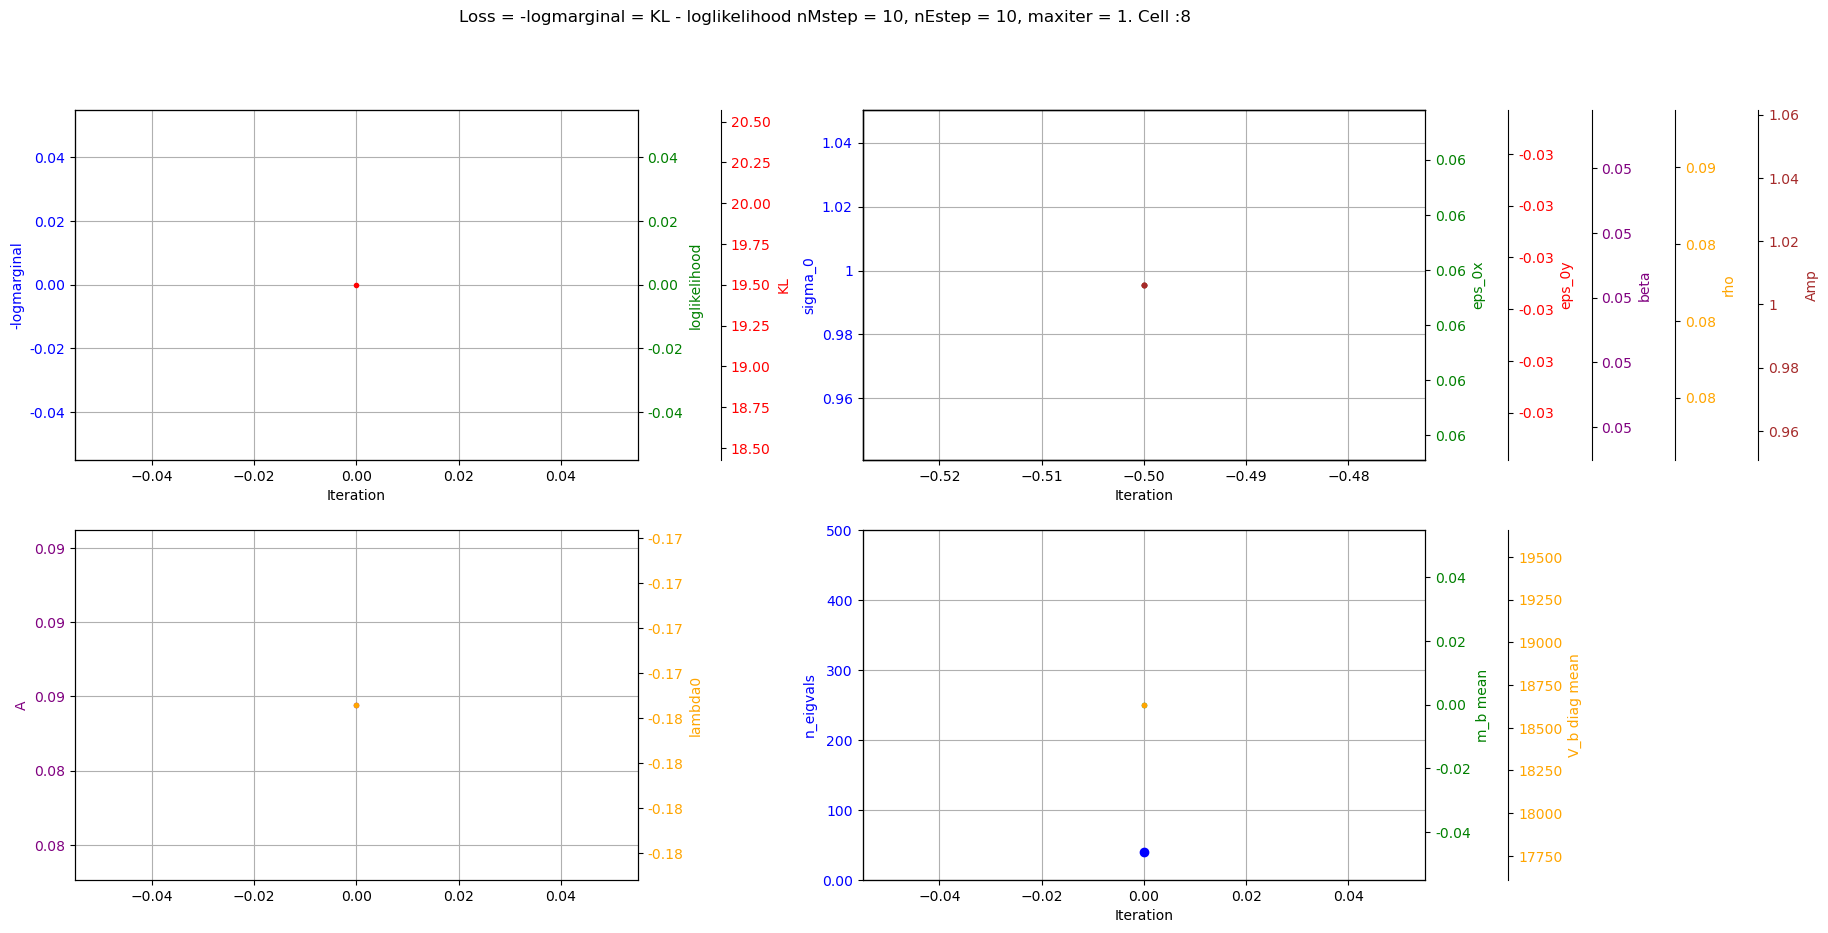

In [ ]:
in_use_idx    = fit_model['fit_parameters']['in_use_idx']
xtilde_idx    = fit_model['fit_parameters']['xtilde_idx']

remaining_idx = all_idx[~torch.isin( all_idx, in_use_idx )].sort()[0]

X_remaining = X[remaining_idx]
R_remaining = R[remaining_idx]

xtilde = X[xtilde_idx]  # This has to be the same as start_model['xtilde']

xstar  = X_remaining

kernfun       = fit_model['fit_parameters']['kernfun']
mask          = fit_model['mask']
C             = fit_model['C']
B             = fit_model['B']
K_tilde_b     = fit_model['K_tilde_b']
K_tilde_inv_b = fit_model['K_tilde_inv_b']
K_b           = fit_model['K_b']
Kvec          = fit_model['Kvec']
m_b           = fit_model['m_b']
V_b           = fit_model['V_b']    
f_params      = fit_model['f_params']
theta         = fit_model['hyperparams_tuple'][0]
A             = torch.exp(f_params['logA'])
lambda0       = torch.exp(f_params['loglambda0']) if 'loglambda0' in f_params else f_params['lambda0']

start_time = time.time()

# Calculate the matrices to compute the lambda moments. They are referred to the unseen images xstar
Kvec_star = utils.acosker(theta, xstar[:,mask], x2=None, C=C, dC=None, diag=True)
K_star    = utils.acosker(theta, xstar[:,mask], x2=xtilde_start[:,mask], C=C, dC=None, diag=False)
K_star_b  = K_star @ B 

lambda_m_t, lambda_var_t = utils.lambda_moments( xstar[:,mask], K_tilde_b, K_star_b@K_tilde_inv_b, Kvec_star, K_star_b, C, m_b, V_b, theta, kernfun)  

logf_mean = A*lambda_m_t + lambda0
logf_var  = A**2 * lambda_var_t

# Estimate the utility and cap the maximum r ( used in a summation to infinity )
r_masked = torch.arange(0, 100, dtype=TORCH_DTYPE)
u2d      = utils.nd_utility(logf_var, logf_mean, r_masked )
print(f'\nElapsed time for lambda moments and utility : {time.time()-start_time:.2f} seconds')  


################

i_best     = u2d.argmax()           # Index of the best image in the utility vector
x_idx_best = remaining_idx[i_best]  # Index of the best image in the dataset indices
print(f'Utility: {u2d[i_best].item():<8.4f} |  Best image ID: {i_best}  | Best image index: {x_idx_best}')


# # Using the indexes of the utility
Kvec_star1 = utils.acosker(theta, xstar[:,mask], x2=None, C=C, dC=None, diag=True)
K_star1    = utils.acosker(theta, xstar[:,mask], x2=xtilde_start[:,mask], C=C, dC=None, diag=False)
K_star1_b  = K_star1 @ B 

lambda_m_t, lambda_var_t = utils.lambda_moments( xstar[:,mask], K_tilde_b, K_star1_b@K_tilde_inv_b, Kvec_star1, K_star1_b, C, m_b, V_b, theta, kernfun)  
logf_mean = A*lambda_m_t + lambda0
logf_var  = A**2 * lambda_var_t

print(f' this has utility {utils.nd_utility(logf_var[i_best], logf_mean[i_best], r_masked)} and f_mean :{torch.exp(logf_mean[i_best]).item():8.4f} Using indexes of utility')


# # Using the indixes of the dataset X
# Calculate the matrices to compute the lambda moments. They are referred to the unseen images xstar
Kvec_star2 = utils.acosker(theta, X[x_idx_best,mask][None,:], x2=None, C=C, dC=None, diag=True)
K_star2    = utils.acosker(theta, X[x_idx_best,mask][None,:], x2=xtilde_start[:,mask], C=C, dC=None, diag=False)
K_star2_b  = K_star2 @ B 
lambda_m_t, lambda_var_t = utils.lambda_moments( X[x_idx_best,mask][None,:], K_tilde_b, K_star2_b@K_tilde_inv_b, Kvec_star2, K_star2_b, C, m_b, V_b, theta, kernfun)  
logf_mean = A*lambda_m_t + lambda0
logf_var  = A**2 * lambda_var_t
print(f' this has utility {utils.nd_utility(logf_var, logf_mean, r_masked)} and f_mean :{torch.exp(logf_mean).item():8.4f} Using indexes of dataset X')

################

if x_idx_best in in_use_idx:
    # print('The best image is already in use')
    raise ValueError('The best image is already in use')

# # Update the remaining and to be used indices. Always sort the indices
in_use_idx    = torch.unique(torch.cat( (in_use_idx, x_idx_best[None]))).sort()[0]  
remaining_idx = all_idx[~torch.isin( all_idx, in_use_idx )].sort()[0]

X_in_use    = X[in_use_idx]
R_in_use    = R[in_use_idx] 
X_remaining = X[remaining_idx]
R_remaining = R[remaining_idx]

# # The added images are used as inducing points as long as the number of inducing points is less than 200
# # if in_use_idx.shape[0] < 200:
xtilde_idx     = in_use_idx
ntilde         = xtilde_idx.shape[0]
xtilde_updated = X[xtilde_idx]                                          # Same as X_in_use

fit_model['xtilde']                       = xtilde_updated
fit_model['fit_parameters']['ntilde']     = ntilde
fit_model['fit_parameters']['in_use_idx'] = in_use_idx
fit_model['fit_parameters']['xtilde_idx'] = xtilde_idx

# Update V_b and m_b to the new size
n                = V_b.shape[0]
V_b_new          = torch.eye(n + 1, dtype=V_b.dtype, device=V_b.device)
V_b_new[:n, :n]  = V_b                                                   # Copy the original V_b into the top-left corner of the new matrix
fit_model['V_b'] = V_b_new 
fit_model['m_b'] = torch.cat( (m_b, torch.zeros(1,dtype=m_b.dtype, 
                                                device=m_b.device)))

print(f'Number of inducing points: {ntilde}')
print(f'Number of images used: {in_use_idx.shape[0]}')
print(f'Shape of the new V_b: {V_b_new.shape[0]}')

fit_model, err_dict = utils.varGP(X_in_use, R_in_use, **fit_model)

spk_count_test, spk_count_pred, r2, sigma_r2 = utils.test(X_test, R_test, X_train=X, at_iteration=None, **fit_model )

utils.plot_loss_and_theta_notebook(fit_model, figsize=(15,10), marker='.')#ylim_logmarg=(0, 5000))

# if err_dict['is_error']:
#     print('Error in the fit')
#     raise err_dict['error']
   


##### The training set has been updated and so has the xtilde

In [10]:
print(f'Number of starting points {X[start_idx].shape[0]}, Number of to be used points    {X_in_use.shape[0]}')
print(f'Number of initial ntilde  {xtilde_start.shape[0]}, Number of to be updated ntilde {xtilde_updated.shape[0]}')

Number of starting points 20, Number of to be used points    21
Number of initial ntilde  20, Number of to be updated ntilde 21


### Loop like this until the selected amount of images has been shown



 Pietro's model: R2 = -0.32 ± 0.01 Cell: 8 maxiter = 15, nEstep = 8, nMstep = 6 



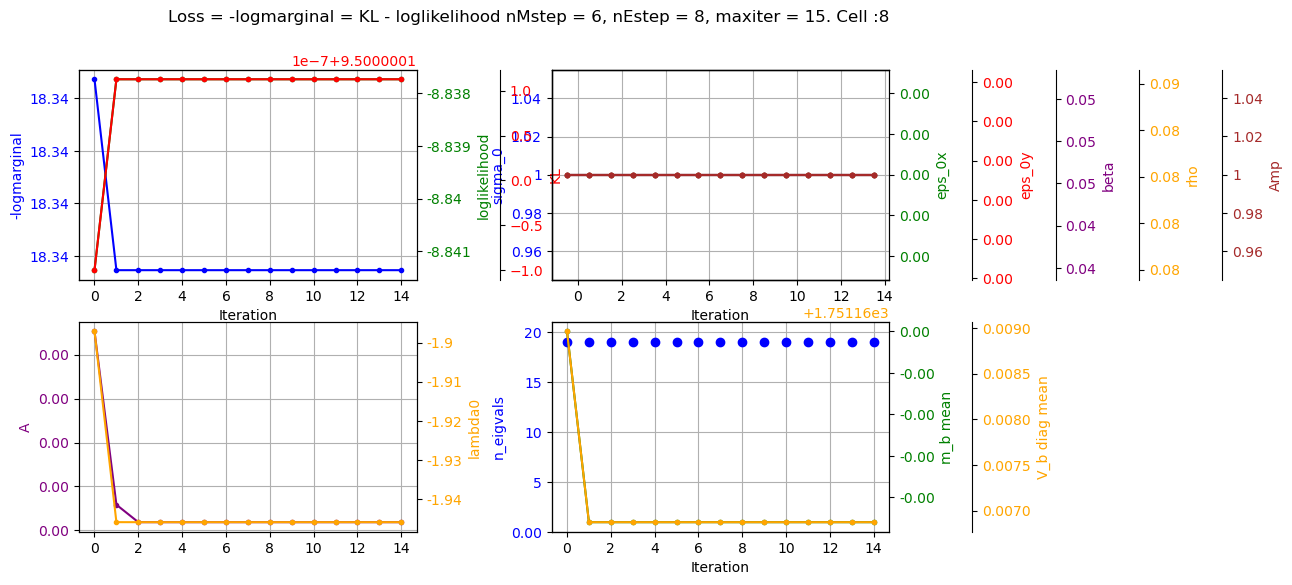

=========== Choosing image number 22 ============
Best utility: 0.0000   | Mean Utility 0.0000   |  Best image ID: 2217 | Best image index: 2232 | Elapsed time for utility: 0.02 seconds
    ========= Number of inducing points going from 21 to 22 =========
*Iteration*:   1 E-step took: 0.0110s, M-step took: 0.0105s
*Iteration*:   2 E-step took: 0.0068s, M-step took: 0.0104s
*Iteration*:   3 E-step took: 0.0064s, M-step took: 0.0105s
*Iteration*:   4 E-step took: 0.0069s, M-step took: 0.0099s
*Iteration*:   5 E-step took: 0.0070s, M-step took: 0.0098s
*Iteration*:   6 E-step took: 0.0070s, M-step took: 0.0101s
*Iteration*:   7 E-step took: 0.0066s, M-step took: 0.0105s
*Iteration*:   8 E-step took: 0.0062s, M-step took: 0.0104s
*Iteration*:   9 E-step took: 0.0063s, M-step took: 0.0104s
*Iteration*:  10 E-step took: 0.0070s, M-step took: 0.0100s
*Iteration*:  11 E-step took: 0.0066s, M-step took: 0.0101s
*Iteration*:  12 E-step took: 0.0068s, M-step took: 0.0097s
*Iteration*:  13 E-step 

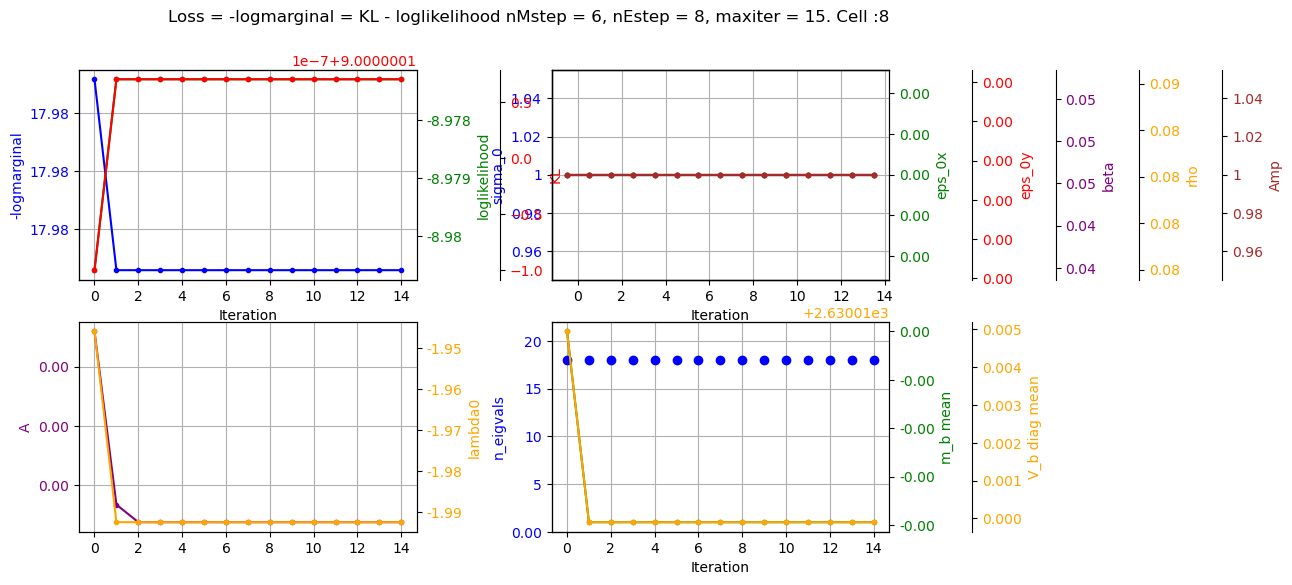

=========== Choosing image number 23 ============
Best utility: 0.0000   | Mean Utility 0.0000   |  Best image ID: 2583 | Best image index: 2602 | Elapsed time for utility: 0.02 seconds
    ========= Number of inducing points going from 22 to 23 =========
*Iteration*:   1 E-step took: 0.0114s, M-step took: 0.0120s
*Iteration*:   2 E-step took: 0.0067s, M-step took: 0.0112s
*Iteration*:   3 E-step took: 0.0067s, M-step took: 0.0105s
*Iteration*:   4 E-step took: 0.0071s, M-step took: 0.0106s
*Iteration*:   5 E-step took: 0.0069s, M-step took: 0.0100s
*Iteration*:   6 E-step took: 0.0071s, M-step took: 0.0103s
*Iteration*:   7 E-step took: 0.0065s, M-step took: 0.0108s
*Iteration*:   8 E-step took: 0.0069s, M-step took: 0.0112s
*Iteration*:   9 E-step took: 0.0068s, M-step took: 0.0112s
*Iteration*:  10 E-step took: 0.0070s, M-step took: 0.0103s
*Iteration*:  11 E-step took: 0.0072s, M-step took: 0.0100s
*Iteration*:  12 E-step took: 0.0064s, M-step took: 0.0104s
*Iteration*:  13 E-step 

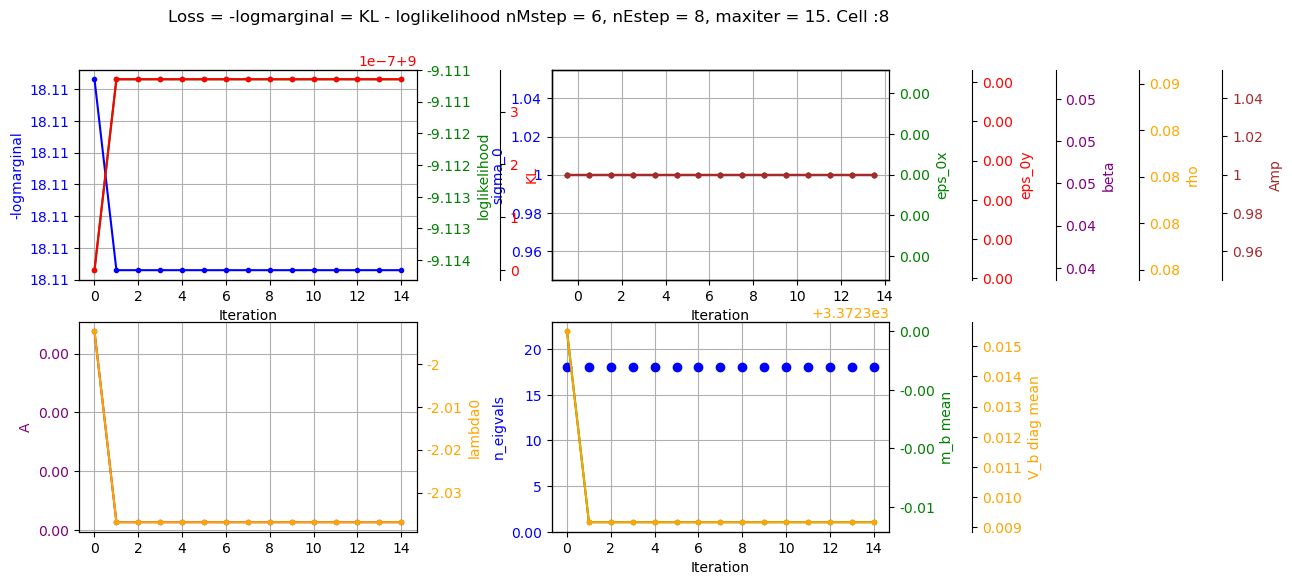

=========== Choosing image number 24 ============
Best utility: 0.0000   | Mean Utility 0.0000   |  Best image ID: 782 | Best image index: 787 | Elapsed time for utility: 0.02 seconds
    ========= Number of inducing points going from 23 to 24 =========
*Iteration*:   1 E-step took: 0.0643s, M-step took: 0.0105s
*Iteration*:   2 E-step took: 0.0428s, M-step took: 0.0101s
*Iteration*:   3 E-step took: 0.0069s, M-step took: 0.0107s
*Iteration*:   4 E-step took: 0.0067s, M-step took: 0.0108s
*Iteration*:   5 E-step took: 0.0073s, M-step took: 0.0106s
*Iteration*:   6 E-step took: 0.0071s, M-step took: 0.0105s
*Iteration*:   7 E-step took: 0.0070s, M-step took: 0.0103s
*Iteration*:   8 E-step took: 0.0067s, M-step took: 0.0104s
*Iteration*:   9 E-step took: 0.0065s, M-step took: 0.0107s
*Iteration*:  10 E-step took: 0.0070s, M-step took: 0.0104s
*Iteration*:  11 E-step took: 0.0072s, M-step took: 0.0102s
*Iteration*:  12 E-step took: 0.0095s, M-step took: 0.0113s
*Iteration*:  13 E-step to

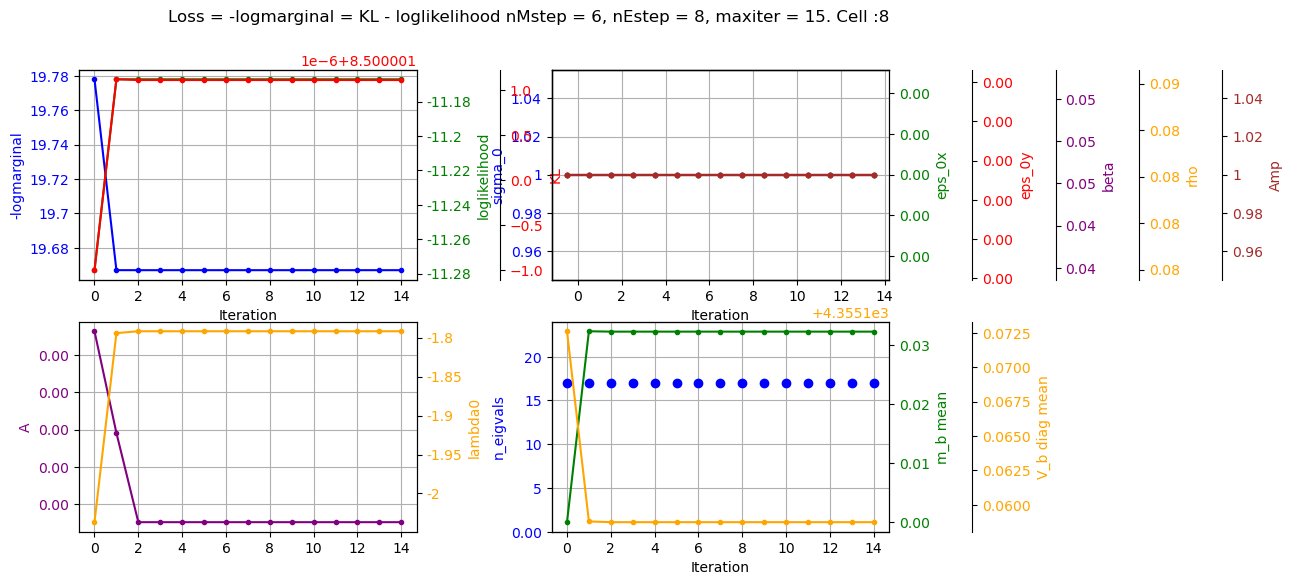

=========== Choosing image number 25 ============
Best utility: 0.0000   | Mean Utility 0.0000   |  Best image ID: 2174 | Best image index: 2189 | Elapsed time for utility: 0.02 seconds
    ========= Number of inducing points going from 24 to 25 =========
*Iteration*:   1 E-step took: 0.0649s, M-step took: 0.0103s
*Iteration*:   2 E-step took: 0.0242s, M-step took: 0.0102s
*Iteration*:   3 E-step took: 0.0064s, M-step took: 0.0106s
*Iteration*:   4 E-step took: 0.0067s, M-step took: 0.0102s
*Iteration*:   5 E-step took: 0.0067s, M-step took: 0.0105s
*Iteration*:   6 E-step took: 0.0075s, M-step took: 0.0103s
*Iteration*:   7 E-step took: 0.0070s, M-step took: 0.0101s
*Iteration*:   8 E-step took: 0.0065s, M-step took: 0.0106s
*Iteration*:   9 E-step took: 0.0064s, M-step took: 0.0107s
*Iteration*:  10 E-step took: 0.0068s, M-step took: 0.0104s
*Iteration*:  11 E-step took: 0.0071s, M-step took: 0.0100s
*Iteration*:  12 E-step took: 0.0067s, M-step took: 0.0099s
*Iteration*:  13 E-step 

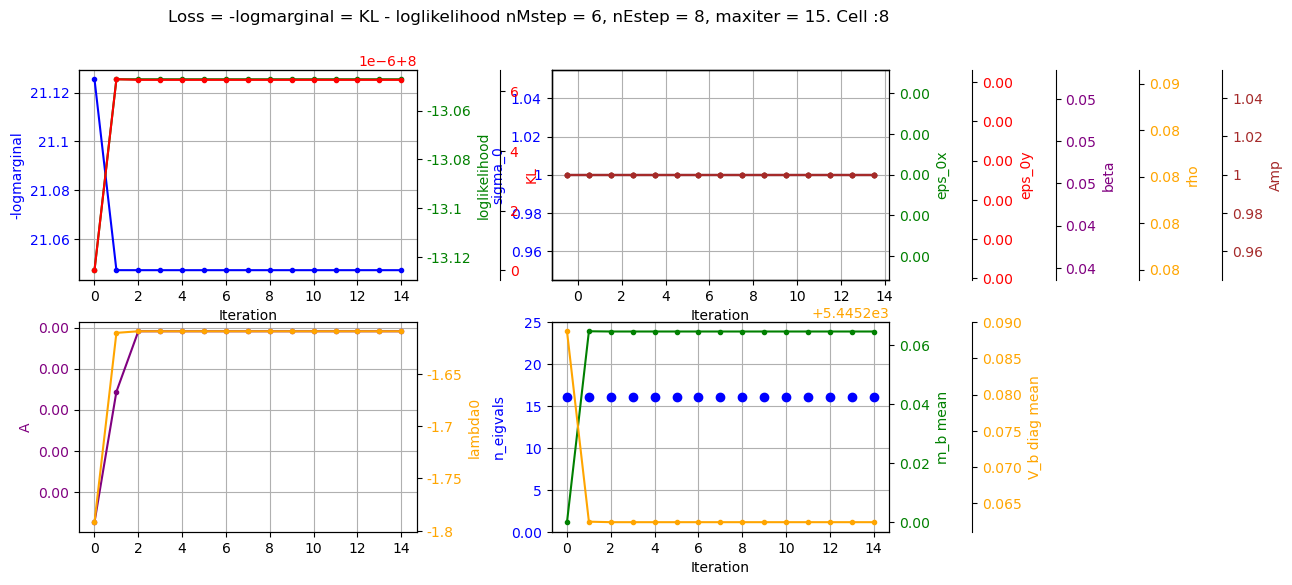

=========== Choosing image number 26 ============
Best utility: 0.0000   | Mean Utility 0.0000   |  Best image ID: 1547 | Best image index: 1556 | Elapsed time for utility: 0.02 seconds
    ========= Number of inducing points going from 25 to 26 =========
*Iteration*:   1 E-step took: 0.0110s, M-step took: 0.0103s
*Iteration*:   2 E-step took: 0.0071s, M-step took: 0.0101s
*Iteration*:   3 E-step took: 0.0067s, M-step took: 0.0101s
*Iteration*:   4 E-step took: 0.0065s, M-step took: 0.0098s
*Iteration*:   5 E-step took: 0.0063s, M-step took: 0.0105s
*Iteration*:   6 E-step took: 0.0063s, M-step took: 0.0103s
*Iteration*:   7 E-step took: 0.0066s, M-step took: 0.0102s
*Iteration*:   8 E-step took: 0.0069s, M-step took: 0.0099s
*Iteration*:   9 E-step took: 0.0072s, M-step took: 0.0105s
*Iteration*:  10 E-step took: 0.0067s, M-step took: 0.0107s
*Iteration*:  11 E-step took: 0.0068s, M-step took: 0.0109s
*Iteration*:  12 E-step took: 0.0065s, M-step took: 0.0104s
*Iteration*:  13 E-step 

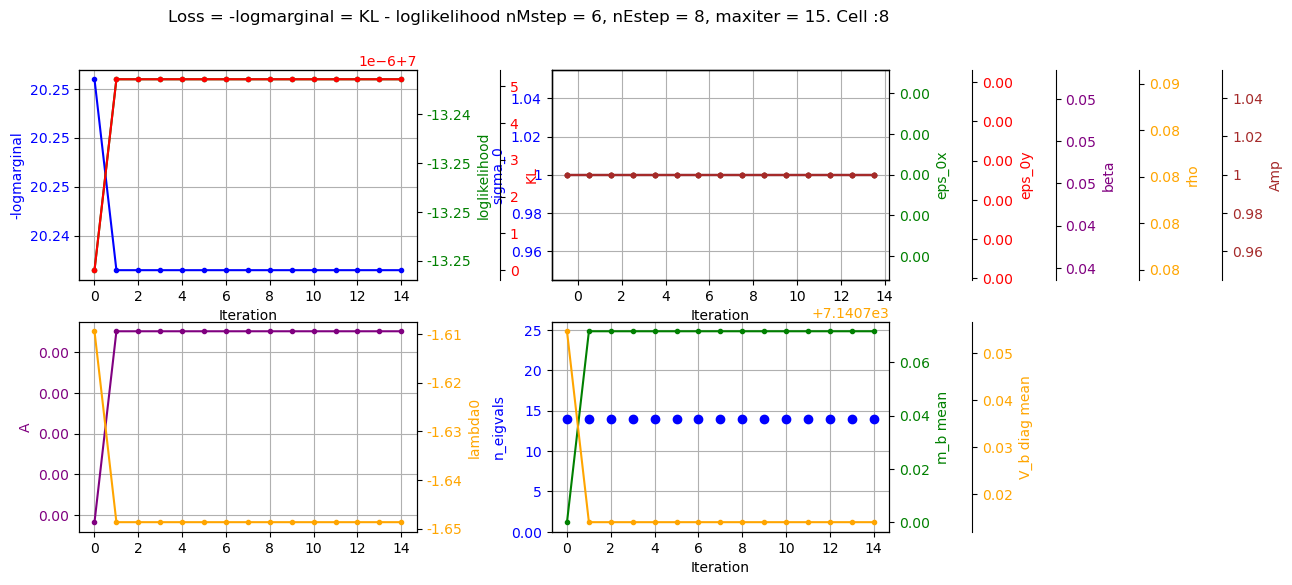

=========== Choosing image number 27 ============
Best utility: 0.0000   | Mean Utility 0.0000   |  Best image ID: 50 | Best image index: 50 | Elapsed time for utility: 0.02 seconds
    ========= Number of inducing points going from 26 to 27 =========
*Iteration*:   1 E-step took: 0.0653s, M-step took: 0.0100s
*Iteration*:   2 E-step took: 0.0291s, M-step took: 0.0107s
*Iteration*:   3 E-step took: 0.0066s, M-step took: 0.0102s
*Iteration*:   4 E-step took: 0.0064s, M-step took: 0.0104s
*Iteration*:   5 E-step took: 0.0071s, M-step took: 0.0100s
*Iteration*:   6 E-step took: 0.0070s, M-step took: 0.0105s
*Iteration*:   7 E-step took: 0.0069s, M-step took: 0.0109s
*Iteration*:   8 E-step took: 0.0065s, M-step took: 0.0107s
*Iteration*:   9 E-step took: 0.0068s, M-step took: 0.0105s
*Iteration*:  10 E-step took: 0.0071s, M-step took: 0.0097s
*Iteration*:  11 E-step took: 0.0069s, M-step took: 0.0098s
*Iteration*:  12 E-step took: 0.0070s, M-step took: 0.0099s
*Iteration*:  13 E-step took

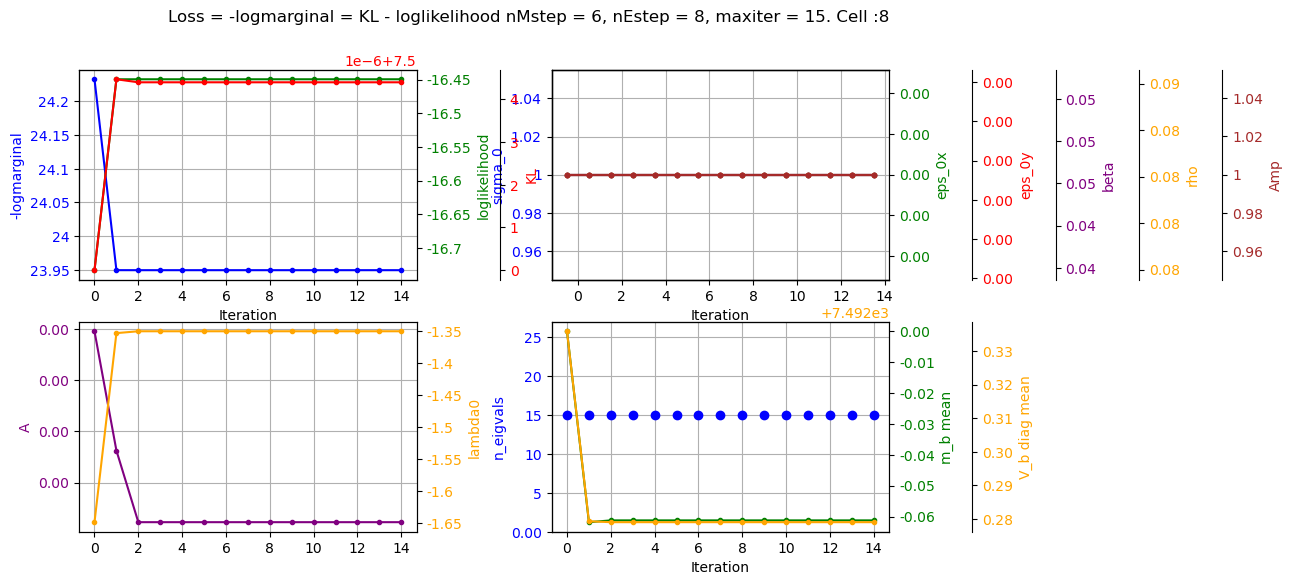

=========== Choosing image number 28 ============
Best utility: 0.0000   | Mean Utility 0.0000   |  Best image ID: 1964 | Best image index: 1981 | Elapsed time for utility: 0.02 seconds
    ========= Number of inducing points going from 27 to 28 =========
*Iteration*:   1 E-step took: 0.0652s, M-step took: 0.0101s
*Iteration*:   2 E-step took: 0.0168s, M-step took: 0.0105s
*Iteration*:   3 E-step took: 0.0071s, M-step took: 0.0098s
*Iteration*:   4 E-step took: 0.0071s, M-step took: 0.0101s
*Iteration*:   5 E-step took: 0.0065s, M-step took: 0.0107s
*Iteration*:   6 E-step took: 0.0066s, M-step took: 0.0109s
*Iteration*:   7 E-step took: 0.0068s, M-step took: 0.0105s
*Iteration*:   8 E-step took: 0.0071s, M-step took: 0.0102s
*Iteration*:   9 E-step took: 0.0072s, M-step took: 0.0101s
*Iteration*:  10 E-step took: 0.0069s, M-step took: 0.0103s
*Iteration*:  11 E-step took: 0.0066s, M-step took: 0.0106s
*Iteration*:  12 E-step took: 0.0066s, M-step took: 0.0103s
*Iteration*:  13 E-step 

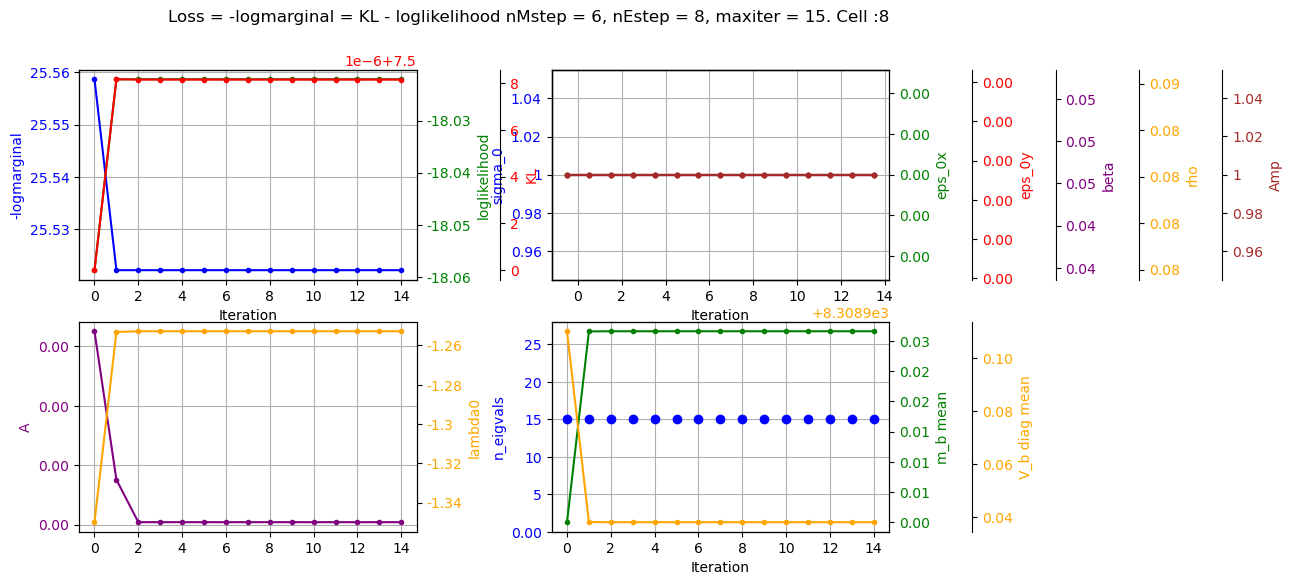

=========== Choosing image number 29 ============
Best utility: 0.0000   | Mean Utility 0.0000   |  Best image ID: 3082 | Best image index: 3110 | Elapsed time for utility: 0.02 seconds
    ========= Number of inducing points going from 28 to 29 =========
*Iteration*:   1 E-step took: 0.0116s, M-step took: 0.0106s
*Iteration*:   2 E-step took: 0.0068s, M-step took: 0.0103s
*Iteration*:   3 E-step took: 0.0065s, M-step took: 0.0107s
*Iteration*:   4 E-step took: 0.0070s, M-step took: 0.0102s
*Iteration*:   5 E-step took: 0.0069s, M-step took: 0.0106s
*Iteration*:   6 E-step took: 0.0075s, M-step took: 0.0102s
*Iteration*:   7 E-step took: 0.0071s, M-step took: 0.0099s
*Iteration*:   8 E-step took: 0.0066s, M-step took: 0.0107s
*Iteration*:   9 E-step took: 0.0064s, M-step took: 0.0107s
*Iteration*:  10 E-step took: 0.0070s, M-step took: 0.0109s
*Iteration*:  11 E-step took: 0.0075s, M-step took: 0.0101s
*Iteration*:  12 E-step took: 0.0074s, M-step took: 0.0101s
*Iteration*:  13 E-step 

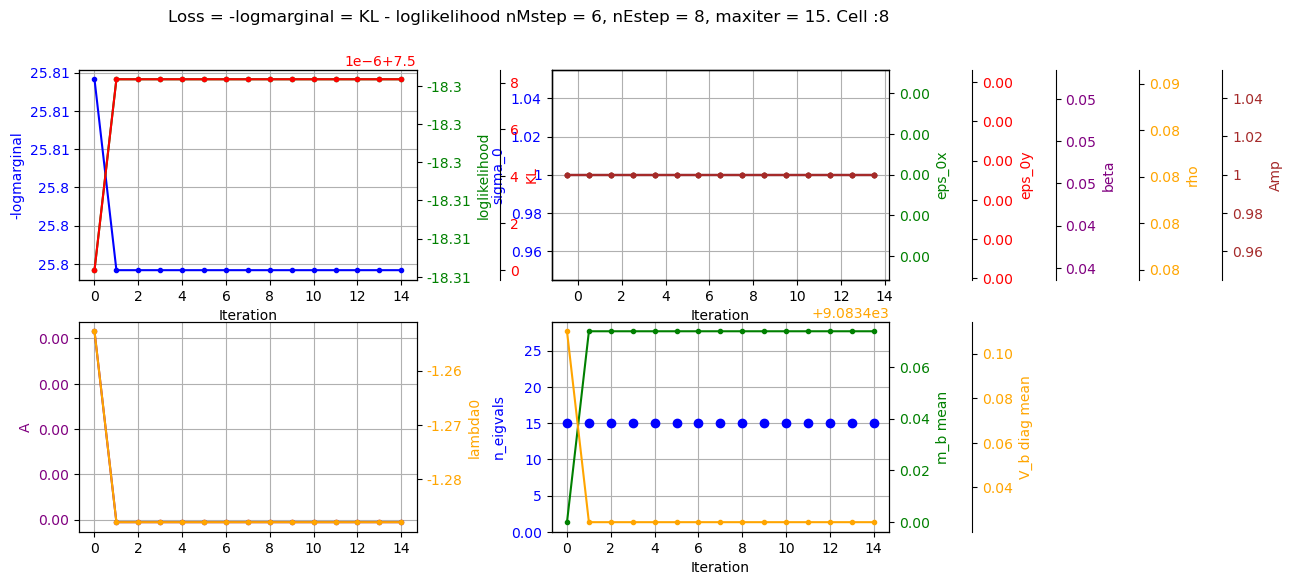

=========== Choosing image number 30 ============
Best utility: 0.0000   | Mean Utility 0.0000   |  Best image ID: 2113 | Best image index: 2131 | Elapsed time for utility: 0.02 seconds
    ========= Number of inducing points going from 29 to 30 =========
*Iteration*:   1 E-step took: 0.0669s, M-step took: 0.0221s
*Iteration*: 2 ===================  Error During iteration: 2 =================== 

During iteration: 2, there should be 2 completed iterations

Time total after init:        0.127s
Time total before init:       0.131s
Final Loss: 33.5579


 Pietro's model: R2 = nan ± nan Cell: 8 maxiter = 2, nEstep = 8, nMstep = 6 



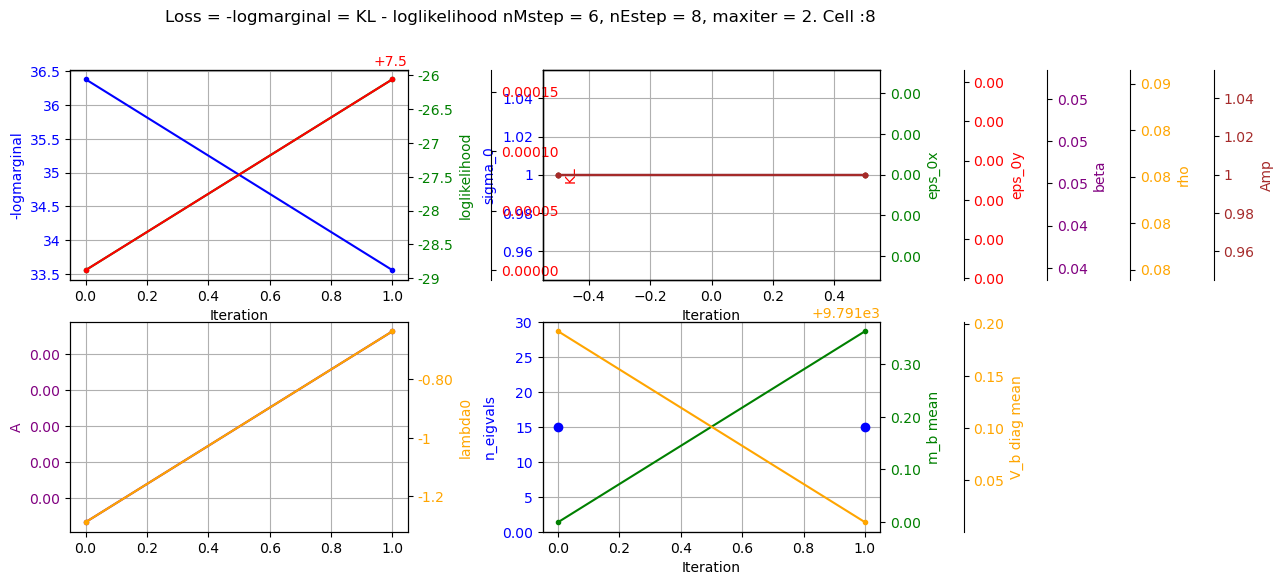

=========== Choosing image number 31 ============
Best utility: 0.0000   | Mean Utility 0.0000   |  Best image ID: 1535 | Best image index: 1545 | Elapsed time for utility: 0.02 seconds
    ========= Number of inducing points capped at 30 =========
*Iteration*: 1 ===================  Error During iteration: 1 =================== 

During iteration: 1, there should be 1 completed iterations
Too few iterations iterations were done to save

Time total after init:        0.006s
Time total before init:       0.010s
Final Loss: nan
Error in the fit while adding image n 31


_LinAlgError: torch.linalg.solve: The solver failed because the input matrix is singular.

In [10]:
n_starting_points = fit_model['fit_parameters']['in_use_idx'].shape[0]
n_imgs_to_show = 50
ntilde_max = 30
r2_vec = torch.zeros(n_imgs_to_show+n_starting_points)

r_capped = torch.arange(0, 100, dtype=TORCH_DTYPE)
for j in range(n_imgs_to_show):
    spk_count_test, spk_count_pred, r2, sigma_r2 = utils.test(X_test, R_test, X_train=X, at_iteration=None, **fit_model )

    r2             = r2
    sigma_r2       = sigma_r2
    txt = f'r^2 = {r2.item():.2f} ± {sigma_r2.item():.2f} ntilde: {ntilde} '
    r2_vec[j] = r2

    utils.plot_loss_and_theta_notebook(fit_model, figsize=(9,6), marker='.')#ylim_logmarg=(0, 5000))

    print(f"=========== Choosing image number {j+n_starting_points+1} ============")
    start_time_utility = time.time()

    kernfun        = fit_model['fit_parameters']['kernfun']
    theta          = fit_model['hyperparams_tuple'][0]
    xtilde_updated = fit_model['xtilde']
    K_tilde_b      = fit_model['K_tilde_b']
    K_tilde_inv_b  = fit_model['K_tilde_inv_b']
    B              = fit_model['B']
    C              = fit_model['C']
    m_b            = fit_model['m_b']
    V_b            = fit_model['V_b']
    mask           = fit_model['mask']
    in_use_idx     = fit_model['fit_parameters']['in_use_idx']
    xtilde_idx     = fit_model['fit_parameters']['xtilde_idx']

    # The matrices to compute the lambda moments are calculated on the unseen images X_remaining (xstar)
    Kvec = utils.acosker(theta, X_remaining[:,mask], x2=None,                   C=C, dC=None, diag=True)
    K    = utils.acosker(theta, X_remaining[:,mask], x2=xtilde_updated[:,mask], C=C, dC=None, diag=False)
    K_b  = K @ B 

    lambda_m_t, lambda_var_t = utils.lambda_moments( X_remaining[:,mask], K_tilde_b, K_b@K_tilde_inv_b, Kvec, K_b, C, m_b, V_b, theta, kernfun)  

    logf_mean = A*lambda_m_t + lambda0
    logf_var  = A**2 * lambda_var_t

    # Estimate the utility with a cappet .arange() vector r( used in a summation to infinity )
    u2d = utils.nd_utility(logf_var, logf_mean, r_capped )

    i_best     = u2d.argmax()
    x_idx_best = remaining_idx[i_best]
    print(f'Best utility: {u2d[i_best].item():<8.4f} | Mean Utility {u2d.mean().item():<8.4f} |  Best image ID: {i_best} | Best image index: {x_idx_best} | Elapsed time for utility: {time.time()-start_time_utility:.2f} seconds')

    in_use_idx    = torch.unique(torch.cat( (in_use_idx, x_idx_best[None]) )).sort()[0]
    remaining_idx = all_idx[~torch.isin( all_idx, in_use_idx )].sort()[0]

    X_in_use    = X[in_use_idx]
    R_in_use    = R[in_use_idx] 
    X_remaining = X[remaining_idx]
    R_remaining = R[remaining_idx]

    # The added images are used as inducing points as long as the number of inducing points is less than 200
    if in_use_idx.shape[0] <= ntilde_max:
        print(f'    ========= Number of inducing points going from {xtilde_idx.shape[0]} to {in_use_idx.shape[0]} =========')
        xtilde_idx     = in_use_idx
        ntilde         = xtilde_idx.shape[0]
        xtilde_updated = X[xtilde_idx]
    else:
        print(f'    ========= Number of inducing points capped at {ntilde_max} =========')
        ntilde = ntilde_max

    fit_model['xtilde'] = xtilde_updated
    fit_model['fit_parameters']['ntilde'] = ntilde
    fit_model['fit_parameters']['in_use_idx'] = in_use_idx
    fit_model['fit_parameters']['xtilde_idx'] = xtilde_idx

    fit_model, err_dict = utils.varGP(X_in_use, R_in_use, **fit_model)

    if err_dict['is_error']:
        print(f'Error in the fit while adding image n {j+n_starting_points+1}')
        raise err_dict['error'] 

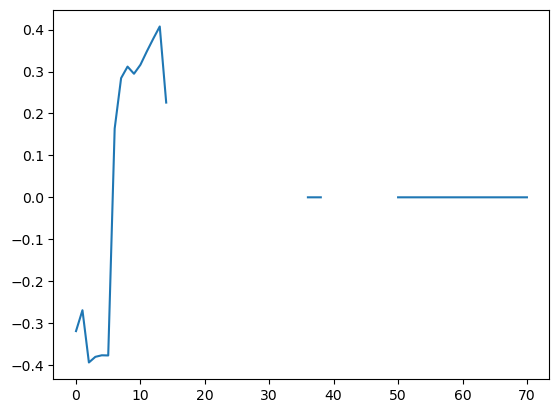

In [ ]:
plt.plot(r2_vec.cpu().numpy())